In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

S x S grid

predicitons = S * S * ( B * 5 + C )

24 convs + 2 fc

pretrain conv on ImageNet

input image = 448 * 448

output = 7 * 7 * 30

In [2]:
class ConvLayers(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=192, kernel_size=7, stride=2, padding=3)  
        self.bn1 = nn.BatchNorm2d(192)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(256)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512)
        )
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3_5 = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
                nn.BatchNorm2d(256),
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
            ) for _ in range(4)]
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
        )
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4_5 = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
                nn.BatchNorm2d(512),
                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),  
                nn.BatchNorm2d(1024),
            ) for _ in range(2)]
        )
        
        # The upper layers are used for pretraining on ImageNet
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),  
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),  
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024)
        )
    
    def preTrain(self, x):
        x = self.maxpool1(F.leaky_relu(self.conv1(x)))
        x = self.maxpool2(F.leaky_relu(self.conv2(x)))
        x = self.maxpool3(F.leaky_relu(self.conv3(x)))
        x = self.maxpool4(F.leaky_relu(self.conv4(x)))
        
        return x
    
    def forward(self, x):
        x = self.maxpool1(F.leaky_relu(self.conv1(x)))
        x = self.maxpool2(F.leaky_relu(self.conv2(x)))
        x = self.maxpool3(F.leaky_relu(self.conv3(x)))
        x = self.maxpool4(F.leaky_relu(self.conv4(x)))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        
        return x

In [3]:
class FCLayers(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(7*7*1024, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 7*7*30)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [4]:
class YOLOv1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convLayers = ConvLayers()
        self.fcLayers = FCLayers()
        
        self.S = 7
        self.B = 2
        self.C = 20
        self.coord_scale = 5
        self.noobj_scale = 0.5
        
    def forward(self, x):
        x = self.convLayers(x)
        x = self.fcLayers(x)
        x = x.view(-1, self.S, self.S, self.B * 5 + self.C)
        return x
    
    def loss_fn(self, predictions, targets):
        pred_bboxes, pred_confs, pred_classes = self.destruct(predictions)
        true_bboxes, true_confs, true_classes = self.destruct(targets)

        iou = self.findIOU(pred_bboxes, true_bboxes)
        best_iou_mask = self.get_best_iou_mask(iou)

        obj_mask = true_confs > 0 
        no_obj_mask = ~obj_mask   

        responsible_mask = torch.zeros_like(pred_confs, dtype=torch.bool)
        responsible_mask.scatter_(-1, best_iou_mask, 1)

        xy_loss = F.mse_loss(
            pred_bboxes[..., :2][obj_mask & responsible_mask],
            true_bboxes[..., :2][obj_mask & responsible_mask],
            reduction='sum'
        )
        wh_loss = F.mse_loss(
            torch.sqrt(pred_bboxes[..., 2:4][obj_mask & responsible_mask] + 1e-6),
            torch.sqrt(true_bboxes[..., 2:4][obj_mask & responsible_mask] + 1e-6),
            reduction='sum'
        )
        bbox_loss = self.coord_scale * (xy_loss + wh_loss)

        obj_conf_loss = F.mse_loss(
            pred_confs[obj_mask & responsible_mask],
            true_confs[obj_mask & responsible_mask],
            reduction='sum'
        )
        
        no_obj_conf_loss = F.mse_loss(
            pred_confs[no_obj_mask],
            true_confs[no_obj_mask],
            reduction='sum'
        )
        conf_loss = obj_conf_loss + self.noobj_scale * no_obj_conf_loss

        grid_obj_mask = obj_mask.any(dim=-1)

        class_loss = F.mse_loss(
            pred_classes[grid_obj_mask],
            true_classes[grid_obj_mask],
            reduction='sum'
        )

        total_loss = bbox_loss + conf_loss + class_loss
        return total_loss / predictions.shape[0] 
    
    def destruct(self, x, B=None):
        if B is None:
            B = self.B 
        bboxes_and_confs = x[..., :B * 5].view(-1, self.S, self.S, B, 5)
        bboxes = bboxes_and_confs[..., :4]
        confs = bboxes_and_confs[..., 4]
        classes = x[..., -self.C:]
        
        return bboxes, confs, classes
    
    def findIOU(self, pred_bboxes, true_bboxes):
        pred_tl, pred_br = self.bbox_to_coords(pred_bboxes)
        true_tl, true_br = self.bbox_to_coords(true_bboxes)
        
        inter_tl = torch.max(pred_tl, true_tl)
        inter_br = torch.min(pred_br, true_br)
        inter_wh = torch.clamp(inter_br - inter_tl, min=0)
        intersection = inter_wh[..., 0] * inter_wh[..., 1]

        pred_area = (pred_br[..., 0] - pred_tl[..., 0]) * (pred_br[..., 1] - pred_tl[..., 1])
        true_area = (true_br[..., 0] - true_tl[..., 0]) * (true_br[..., 1] - true_tl[..., 1])
        union = pred_area + true_area - intersection

        return intersection / (union + 1e-6)

    def bbox_to_coords(self, bboxes):
        x, y, w, h = bboxes[..., 0], bboxes[..., 1], bboxes[..., 2], bboxes[..., 3]
        tl = torch.stack((x - w / 2, y - h / 2), dim=-1)
        br = torch.stack((x + w / 2, y + h / 2), dim=-1)
        return tl, br

    def get_best_iou_mask(self, iou):
        best_iou_idx = torch.argmax(iou, dim=-1)
        return best_iou_idx.unsqueeze(-1)

In [5]:
model = YOLOv1()
x = torch.randn(1, 3, 448, 448)
x = model(x)
print(x.shape)

# y = torch.randn(1, 7, 7, 25)
# # loss = model.loss_fn(x, y)
# bb, c, cc = model.destruct(y, 1)
# print(c.shape)
# print(cc.shape)

torch.Size([1, 7, 7, 30])


In [9]:
import xml.etree.ElementTree as ET

def parse_voc_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    objects = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        objects.append({"name": name, "bbox": [xmin, ymin, xmax, ymax]})
    
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    return objects, width, height

In [16]:
def encode_target(objects, width, height, S=7, B=2, C=20, class_map=None):
    target = torch.zeros((S, S, B * 5 + C))
    for obj in objects:
        name = obj["name"]
        bbox = obj["bbox"]

        xmin, ymin, xmax, ymax = bbox
        x_center = (xmin + xmax) / 2 / width
        y_center = (ymin + ymax) / 2 / height
        box_width = (xmax - xmin) / width
        box_height = (ymax - ymin) / height

        # Determine grid cell
        grid_x = int(x_center * S)
        grid_y = int(y_center * S)

        # Assign the bounding box to the first predictor
        cell_x = x_center * S - grid_x
        cell_y = y_center * S - grid_y
        target[grid_y, grid_x, :5] = torch.tensor([cell_x, cell_y, box_width, box_height, 1])

        class_idx = class_map[name]
        target[grid_y, grid_x, 5 + class_idx] = 1

    return target

In [19]:
xml_file = "C://ML Resume//YOLO from scratch//dataset//VOCtrainval_06-Nov-2007//VOCdevkit//VOC2007//Annotations//000005.xml"
class_names = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", 
    "bus", "car", "cat", "chair", "cow", 
    "diningtable", "dog", "horse", "motorbike", "person", 
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

class_map = {class_name: idx for idx, class_name in enumerate(class_names)}

objects, width, height = parse_voc_xml(xml_file)
target = encode_target(objects, width, height, S=7, B=2, C=20, class_map=class_map)

target = target.unsqueeze(0)

In [24]:
model = YOLOv1()
x = torch.randn(1, 3, 448, 448)
x = model(x)
print(x.shape)
print(target.shape)
loss = model.loss_fn(x, target)
print(loss)

torch.Size([1, 7, 7, 30])
torch.Size([1, 7, 7, 30])
tensor(nan, grad_fn=<DivBackward0>)


In [25]:
bboxes, confs, classes =  model.destruct(target)

In [27]:
bboxes.shape

torch.Size([1, 7, 7, 2, 4])

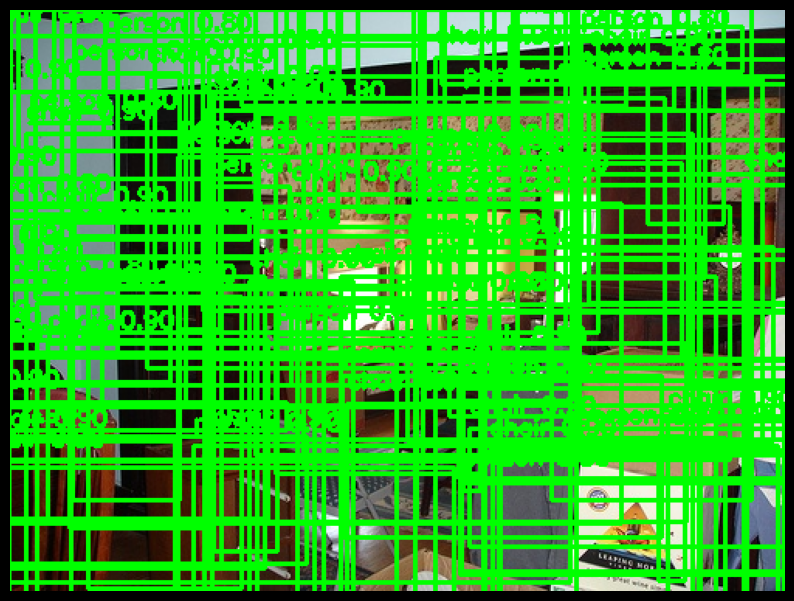

In [28]:
import torch
import cv2
import matplotlib.pyplot as plt

def decode_bboxes(bboxes, grid_size, img_width, img_height):
    """
    Decode YOLO bounding boxes from relative grid positions to absolute pixel values.

    Args:
        bboxes (torch.Tensor): Bounding boxes with shape [1, grid_size, grid_size, num_bboxes, 4].
        grid_size (int): Size of the grid (e.g., 7 for a 7x7 grid).
        img_width (int): Width of the original image.
        img_height (int): Height of the original image.

    Returns:
        List of decoded bounding boxes in absolute pixel coordinates.
    """
    bboxes = bboxes.squeeze(0)  # Remove batch dimension
    decoded_bboxes = []
    cell_size_x = img_width / grid_size
    cell_size_y = img_height / grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            for bbox in bboxes[i, j]:
                x_center, y_center, width, height = bbox

                # Convert from relative grid position to absolute image coordinates
                x_center_abs = (j + x_center) * cell_size_x
                y_center_abs = (i + y_center) * cell_size_y
                width_abs = width * img_width
                height_abs = height * img_height

                x_min = int(x_center_abs - width_abs / 2)
                y_min = int(y_center_abs - height_abs / 2)
                x_max = int(x_center_abs + width_abs / 2)
                y_max = int(y_center_abs + height_abs / 2)

                decoded_bboxes.append([x_min, y_min, x_max, y_max])
    return decoded_bboxes

def draw_decoded_bboxes(image, decoded_bboxes, confs=None, classes=None, class_map=None):
    """
    Draws decoded bounding boxes on the image.

    Args:
        image (ndarray): The image to draw on (H, W, C).
        decoded_bboxes (list): List of bounding boxes in (x_min, y_min, x_max, y_max) format.
        confs (list): Optional confidence scores for each bounding box.
        classes (list): Optional class IDs for each bounding box.
        class_map (dict): Mapping of class IDs to class names.
    """
    img = image.copy()
    for idx, bbox in enumerate(decoded_bboxes):
        x_min, y_min, x_max, y_max = bbox

        # Draw the rectangle
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Add confidence score and class label if provided
        label = ""
        if classes and class_map:
            class_id = classes[idx]
            class_name = list(class_map.keys())[list(class_map.values()).index(class_id)]
            label += class_name
        if confs:
            label += f" {confs[idx]:.2f}"
        if label:
            cv2.putText(img, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img

# Example image
image_path = "C://ML Resume//YOLO from scratch//dataset//VOCtrainval_06-Nov-2007//VOCdevkit//VOC2007//JPEGImages//000005.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width = image.shape[:2]

# Example bboxes (random, replace with actual model output)
grid_size = 7
bboxes = torch.rand(1, grid_size, grid_size, 2, 4)  # Random for demonstration

decoded_bboxes = decode_bboxes(bboxes, grid_size, img_width, img_height)

confs = [0.9, 0.8] * (grid_size * grid_size)  # Placeholder confidence
classes = [8, 14] * (grid_size * grid_size)  # Placeholder classes

# Draw decoded bounding boxes
annotated_image = draw_decoded_bboxes(image, decoded_bboxes, confs, classes, class_map)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()
